In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Set model parameters

In [2]:
# Set outcome
outcome = 'pH'

# Threshold to define outcome as abnormal or not
outcome_threshold = 7.15

## Load data

In [3]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './ctu-data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [4]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split(os.sep)[-1]
        csv_files[filename_short] =  pd.read_csv(os.path.join(paths.data, file))
        
print(csv_files.keys())

dict_keys(['1012', '1006', '1210', '1204', '2043', '1238', '1402', '1364', '1370', '1416', '1358', '1199', '1166', '1172', '1173', '1167', '1198', '1359', '1371', '1417', '1403', '1365', '1239', '2042', '1205', '1211', '1007', '1013', '1005', '1011', '1039', '1207', '1213', '2040', '1398', '1415', '1373', '1367', '1401', '1429', '1171', '1165', '1159', '1158', '1164', '1170', '1428', '1366', '1400', '1414', '1372', '1399', '2041', '1212', '1206', '1038', '1010', '1004', '1028', '1014', '2045', '1202', '1216', '1389', '1438', '1376', '1410', '1404', '1362', '1148', '1174', '1160', '1161', '1175', '1149', '1405', '1363', '1377', '1411', '1439', '1388', '1217', '1203', '2044', '1015', '1001', '1029', '1017', '1003', '1229', '2046', '1215', '1201', '1349', '1361', '1407', '1413', '1375', '1188', '1163', '1177', '1176', '1162', '1189', '1412', '1374', '1360', '1406', '1348', '1200', '1214', '1228', '1002', '1016', '1071', '1065', '1059', '1298', '1273', '1501', '2008', '1267', '2020', '2034

In [5]:
# Load meta data and transform
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')
metadata.head()

,1220,1234,1208,1038,1004,1010,1022,1036,2041,1206,...,1079,1290,1284,1077,1063,1088,1253,1247,2028,2014
parameter,,,,,,,,,,,,,,,,,,,,,
pH,7.30,7.29,7.23,7.33,7.30,7.35,7.28,7.08,7.37,7.24,...,7.17,7.36,7.16,7.22,7.16,7.25,7.32,7.32,7.18,7.32
BDecf,3.52,2.50,5.84,2.72,5.19,5.20,1.53,8.11,3.69,2.06,...,7.91,3.88,5.07,6.69,5.56,2.58,0.89,-0.86,4.82,2.28
pCO2,6.00,6.50,6.60,5.70,5.50,4.70,7.00,9.30,4.80,7.70,...,7.10,4.90,8.50,6.50,8.30,7.30,6.40,6.90,8.10,6.00
BE,-4.70,-4.20,-7.40,-4.00,-6.40,-5.90,-3.00,-11.20,-3.10,-4.00,...,-9.90,-4.10,-7.30,-8.00,-7.90,-4.50,-1.70,-1.00,-7.20,-3.20
Apgar1,9.00,8.00,9.00,10.00,8.00,8.00,10.00,8.00,9.00,9.00,...,8.00,9.00,10.00,6.00,9.00,8.00,8.00,9.00,8.00,10.00


## View outcome

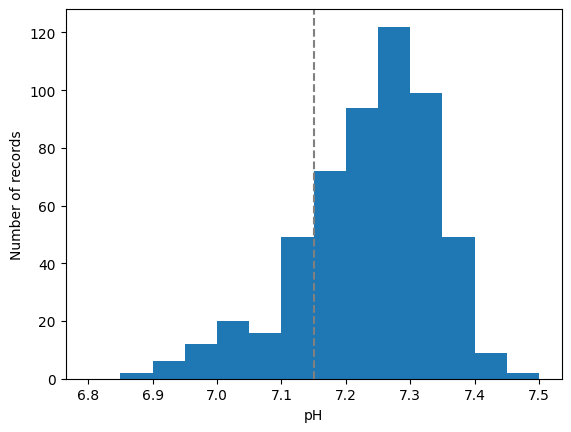

In [6]:
plt.hist(metadata.loc[outcome], bins=np.arange(6.8, 7.5, 0.05))
plt.xlabel(outcome)
plt.ylabel('Number of records')
plt.axvline(x=outcome_threshold, color='grey', linestyle='--')

## Clean the data

In [7]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    fhr = fhr.interpolate(method='cubic')

    # Drop any remaining missing values (e.g. if at start of time series)
    fhr = fhr.dropna()

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Keep the last 30 minutes
    fhr = fhr.tail(4*30*60)

    return(fhr.values)

In [8]:
# from utils.calculate_expert_feature import calculate_features
fhr_dict = {}
feature_dict = {}
for key, value in csv_files.items():
    fhr_dict[key] = clean_fhr(value.FHR)
    # feature_dict[key] = calculate_features(fhr_dict[key])

## Define x and y

In [9]:
# Set x as the signals from the dictionary
X_fhr = list(fhr_dict.values())
print(type(X_fhr[0]))

# X_feature = list(feature_dict.values())
# print(type(X_feature[0]))

# Y is a boolean, true/false for each depending on outcome
# We set order of metadata according to dictionary keys so they match up
y = (metadata[fhr_dict.keys()].loc[outcome] < outcome_threshold).values
y = y.astype(np.int8)
print(y)

<class 'numpy.ndarray'>
[0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 

## Define training and testing

In [10]:
# X_fhr_train, X_fhr_test, X_feature_train, X_feature_test, y_train, y_test = train_test_split(
#     X_fhr, X_feature, y, test_size = 0.25, random_state=42)
X_fhr_train, X_fhr_test, y_train, y_test = train_test_split(
    X_fhr, y, test_size = 0.25, random_state=42)

print(np.bincount(y_train)) # 打印训练集中每个标签的出现次数
print(np.bincount(y_test)) # 打印测试集中每个标签的出现次数

[330  84]
[117  21]


## Scale data

In [11]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [12]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_fhr_train, X_fhr_test)

# X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
# X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

n_classes = len(np.unique(y_train))
print('the number of train data', X_train_sc.shape)
print('the number of test data', X_test_sc.shape)
print(type(X_train_sc))

the number of train data (414, 7200)
the number of test data (138, 7200)
<class 'numpy.ndarray'>


## KNN

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utils import evaluate
from xgboost import XGBClassifier
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_sc, y_train)

y_pred = model_knn.predict(X_test_sc)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, y_pred) # 计算预测结果y_pred与真实标签y_test之间的准确率
print("Accuracy: %.2f%%" % (accuracy * 100.0))

evaluate.evaluate_model(model_knn, X_test_sc, y_test)

Accuracy: 84.78%
Accuracy:- 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       117
           1       0.00      0.00      0.00        21

    accuracy                           0.85       138
   macro avg       0.42      0.50      0.46       138
weighted avg       0.72      0.85      0.78       138



/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## FHR classify base on SVM 

In [24]:
model_svc = SVC(kernel='linear')
model_svc.fit(X_train_sc, y_train)

evaluate.evaluate_model(model_svc, X_test_sc, y_test)


Accuracy:- 71.74%
Confusion matrix :- 
 [[91 26]
 [13  8]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.88      0.78      0.82       117
           1       0.24      0.38      0.29        21

    accuracy                           0.72       138
   macro avg       0.56      0.58      0.56       138
weighted avg       0.78      0.72      0.74       138



In [15]:
model = SVC(kernel='rbf')
model.fit(X_train_sc, y_train)

evaluate.evaluate_model(model, X_test_sc, y_test)

Accuracy:- 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       117
           1       0.00      0.00      0.00        21

    accuracy                           0.85       138
   macro avg       0.42      0.50      0.46       138
weighted avg       0.72      0.85      0.78       138



/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## Random Forest Classifier

In [25]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train_sc, y_train)

evaluate.evaluate_model(model_rfc, X_test_sc, y_test)

Accuracy:- 84.06%
Confusion matrix :- 
 [[115   2]
 [ 20   1]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       117
           1       0.33      0.05      0.08        21

    accuracy                           0.84       138
   macro avg       0.59      0.52      0.50       138
weighted avg       0.77      0.84      0.79       138



## XGBoost

In [26]:
from xgboost import XGBClassifier
model_xg = XGBClassifier(eval_metric='mlogloss', objective='binary:logistic', use_label_encoder=False)
model_xg.fit(X_train_sc, y_train)

evaluate.evaluate_model(model_xg, X_test_sc, y_test)

/Users/lijingquan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy:- 84.06%
Confusion matrix :- 
 [[114   3]
 [ 19   2]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       117
           1       0.40      0.10      0.15        21

    accuracy                           0.84       138
   macro avg       0.63      0.53      0.53       138
weighted avg       0.79      0.84      0.80       138



AUC ROC Scores
XGBoost: 	 0.5347985347985348
RandomForest: 	 0.5152625152625152
SupportVectorMachines: 	 0.5793650793650794
KNN: 	 0.5


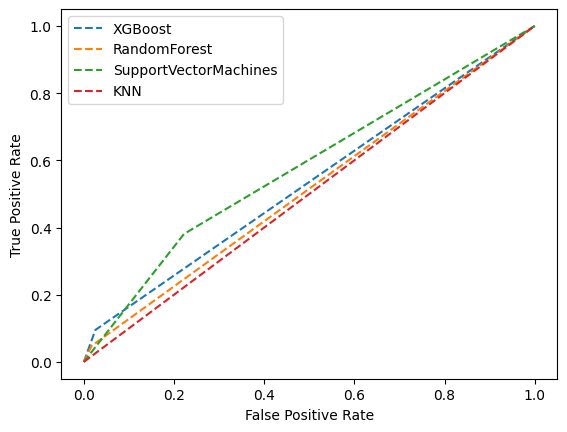

In [27]:
evaluate.plot_auc_roc([('XGBoost', model_xg), ('RandomForest', model_rfc), ('SupportVectorMachines', model_svc), ('KNN', model_knn)], X_test_sc, y_test)

## FHR classify base on NN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math


# 定义MDSC模块
class MDSC(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super(MDSC, self).__init__()
        self.conv1 = nn.Sequential( # 一个序列化的卷积模块
            # 第一个nn.Conv1d是一个一维卷积层，输入通道和输出通道相同，卷积核大小为1，使用分组卷积
            nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, padding=0, groups=in_channels),
            # 第二个nn.Conv1d是一个一维卷积层，将通道数从in_channels变为out_channels，卷积核大小为1
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels), # 批量归一化层，归一化输出通道
            nn.ReLU(), # 激活函数层，使用ReLU激活函数
            nn.Dropout(dropout) # dropout层，按给定的概率丢弃一些神经元
        )
        self.conv2 = nn.Sequential( # 另一个序列化的卷积模块，类似self.conv1
            # 第一个卷积层的卷积核大小为3，填充为1，保持输入输出的宽度相同
            nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, groups=in_channels),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential( # 第三个序列化的卷积模块
            # 第一个卷积层的卷积核大小为5，填充为2，保持输入输出的宽度相同
            nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=5, padding=2, groups=in_channels),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential( # 第四个序列化的卷积模块
            # 第一个卷积层的卷积核大小为7，填充为3，保持输入输出的宽度相同
            nn.Conv1d(in_channels=in_channels, out_channels=in_channels, kernel_size=7, padding=3, groups=in_channels),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x): # 定义前向传播过程
        # 输入x经过四个卷积模块，分别得到x1、x2、x3和x4
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        x = torch.cat([x1, x2, x3, x4], dim=1) # 将四个卷积模块的输出在通道维度上连接起来
        return x # 返回拼接后的结果


class Chomp1d(nn.Module):
    def __init__(self, chomp_size): # chomp_size是截取的大小，它表示要截去输入张量末尾的多少个元素
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x): # 定义前向传播过程，x是输入的张量
        return x[:, :, :-self.chomp_size].contiguous() # 在最后一个维度上从末尾截去chomp_size个元素，contiguous()方法确保返回的张量在内存中是连续的


# 定义SEBlock
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16): # channel是输入通道数，reduction是通道压缩比例，默认值是16
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1) # 自适应平均池化层，将输入的每个通道的长度缩小到1
        self.fc = nn.Sequential( # self.fc是一个全连接层的序列化模块
            nn.Linear(channel, channel // reduction, bias=False), # 第一个nn.Linear层将通道数从channel减少到channel // reduction，且不使用偏置
            nn.ReLU(inplace=True), # ReLU激活函数层，使用就地操作来减少内存占用
            nn.Linear(channel // reduction, channel, bias=False), # 第二个nn.Linear层将通道数从channel // reduction增加回channel，同样不使用偏置
            nn.Sigmoid() # Sigmoid激活函数层，将输出值缩放到0到1之间
        )

    def forward(self, x): # forward方法定义了前向传播过程，x是输入的张量
        b, c, _ = x.size() # b是批次大小，c是通道数，_是输入的长度（不需要具体用到）
        # self.avg_pool(x)对输入x进行自适应平均池化，结果是一个大小为(b, c, 1)的张量
        # .view(b, -1)将池化后的张量展平为大小为(b, c)的二维张量
        # self.fc(...)将展平后的张量输入全连接层序列进行处理
        # .view(b, c, -1)将全连接层的输出重新调整为大小为(b, c, 1)的张量
        avg_out = self.fc(self.avg_pool(x).view(b, -1)).view(b, c, -1) 
        out = x * avg_out.expand_as(x) # 将avg_out的大小扩展到和输入x相同的大小，x * avg_out对输入x进行通道加权（逐元素相乘），实现SE模块的重新校准
        return out # 返回加权后的张量out


class SETCNBlock(nn.Module):
    # 参数n_inputs是输入通道数，n_outputs是输出通道数，kernel_size是卷积核大小，stride是步幅
    #  dilation是膨胀系数，padding是填充大小，dropout是dropout概率，默认值是0.2
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(SETCNBlock, self).__init__()
        # self.conv1是一个一维卷积层，输入通道是n_inputs，输出通道是n_outputs
        # 卷积核大小是kernel_size，步幅为1，填充为padding，膨胀系数为dilation
        # 使用了weight_norm来标准化权重
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=1, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding) # self.chomp1是一个Chomp1d层，用来截取卷积后的张量
        self.bn1 = nn.BatchNorm1d(n_outputs) # self.bn1是批量归一化层，用来对输出通道进行归一化
        self.relu1 = nn.ReLU() # ReLU激活函数层
        self.dropout1 = nn.Dropout(dropout) # dropout层，按给定的概率丢弃一些神经元

        # 第二个一维卷积层，输入和输出通道数相同，其他参数与conv1类似
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 另一个Chomp1d层，截取的大小是padding除以stride的上限值
        self.chomp2 = Chomp1d(math.ceil(padding / stride))

        # self.net是一个序列化的模块，包含了conv1、chomp1、bn1、relu1、dropout1、conv2和chomp2
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2)
        # self.downsample是一个一维卷积层，用于调整输入x的通道数和步幅，使其与主路径的输出相匹配
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1, stride=stride) 
        self.se_block = SEBlock(n_outputs) # 一个SE模块，用于通道间的重新校准
        self.relu = nn.ReLU() # ReLU激活函数层
        self.init_weights() # 一个初始化权重的方法

    def init_weights(self): # 初始化卷积层的权重，将其设置为服从均值为0、标准差为0.01的正态分布
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None: # 如果downsample不为空，也对其权重进行初始化
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        res = self.se_block(res)
        return self.relu(out + res) # 最终返回out和res的和，再经过ReLU激活函数


class SETCN(nn.Module):
    # 参数num_inputs是输入通道数，num_channels是每一层的输出通道数的列表
    # kernel_size是卷积核大小，默认值为2，dropout是dropout概率，默认值为0.2
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(SETCN, self).__init__()
        layers = [] # layers是一个空列表，用于存储每一层的SETCNBlock
        num_levels = len(num_channels) # num_channels的长度，即有多少层
        strides = [2, 2, 2, 2, 10] # 每一层的步幅，定义了五层的步幅分别是2、2、2、2、10
        for i in range(num_levels):
            dilation_size = 2 ** (i+1) # 膨胀系数，按照2的幂次方递增
            in_channels = num_inputs if i == 0 else num_channels[i-1] # 输入通道数，如果是第一层，则等于num_inputs，否则等于前一层的输出通道数
            out_channels = num_channels[i] # 输出通道数，等于当前层的num_channels值
            layers += [SETCNBlock(in_channels, out_channels, kernel_size, stride=strides[i], dilation=dilation_size,
                                     padding=(kernel_size -1) * dilation_size, dropout=dropout)] # layers列表中添加一个新的SETCNBlock实例

        self.network = nn.Sequential(*layers) # 一个序列化的模块，包含了layers列表中的所有层

    def forward(self, x):
        return self.network(x)


## create model
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes): # 参数input_size是输入的特征数量，num_classes是输出的类别数量
        super(SimpleNeuralNetwork, self).__init__()

        self.mdsc = MDSC(input_size, 16) # 一个MDSC模块的实例，将输入特征数量input_size作为输入通道数，输出通道数设为16
        self.setcn_blocks = SETCN(64, [64, 64, 128, 128, 256], kernel_size=15) # 一个SETCN模块的实例，输入通道数设为64，输出通道数按照列表顺序为64、64、128、128、256，卷积核大小为15

        self.avg_pool = nn.AdaptiveAvgPool1d(1) # 自适应平均池化层，将每个通道的长度缩小到1
        # 一个全连接层的序列化模块
        self.fc = nn.Sequential(nn.Linear(256, 64), # 第一个nn.Linear层将输入的通道数从256减少到64
                                nn.Dropout(0.6), # dropout层，按60%的概率丢弃一些神经元
                                nn.ReLU(),
                                nn.Linear(64, num_classes)) # 第二个nn.Linear层将输入的通道数从64减少到num_classes，即输出类别的数量

    def forward(self, x):
        x = self.mdsc(x)
        x = self.setcn_blocks(x)
        b, c, _ = x.size() # 获取x的尺寸，其中b是批次大小，c是通道数，_是输入的长度
        out = self.fc(self.avg_pool(x).view(b, -1)) # 使用self.avg_pool(x)对输入x进行自适应平均池化，结果是一个大小为(b, c, 1)的张量

        return out


In [29]:
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, num_epochs, train_loader, test_loader, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.history = {'train_loss': [], 'test_loss': [], 'test_accuracy': [], 'train_accuracy': []}
        self.device = device 
        self.best_acc = 0.0
        self.best_model = None
    
    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0
            
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                
                # 计算训练准确率
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_accuracy = 100 * correct_predictions / total_predictions
            self.history['train_loss'].append(epoch_loss)
            self.history['train_accuracy'].append(train_accuracy)
            
            print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            
            self.validate()
        
        self.plot_loss()
        self.plot_acc()

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            correct_predictions = 0
            total_predictions = 0
            test_loss = 0.0
            y_true = []
            y_pred = []
            
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
            
            test_loss /= len(self.test_loader.dataset)
            test_accuracy = 100 * correct_predictions / total_predictions
            if test_accuracy > self.best_acc:
                self.best_acc = test_accuracy
                self.best_model = self.model.state_dict()

            self.history['test_loss'].append(test_loss)
            self.history['test_accuracy'].append(test_accuracy)
            
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
            print('Confusion matrix :- \n', confusion_matrix(y_true, y_pred))
    
    def save_best_model(self):
        torch.save(self.best_model, 'best_model.pth')
    
    def test_with_best_model(self):
        self.model.load_state_dict(self.best_model)
        self.model.eval()
        with torch.no_grad():
            y_true = []
            y_scores = []
            y_pred = []
            correct_predictions = 0
            total_predictions = 0

            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_scores.extend(probabilities[:, 1].cpu().numpy())

            test_accuracy = 100 * correct_predictions / total_predictions
            print(f'Test Acc: {test_accuracy:.2f}%')
            print('Confusion matrix :- \n', confusion_matrix(y_true, y_pred))
            print("Classification Report:-\n", classification_report(y_true, y_pred))

        # 绘制ROC曲线
        self.plot_roc_curve(np.array(y_true), np.array(y_scores))

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['test_loss'], label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Over Epochs')
        plt.legend()
        plt.show()
    
    def plot_acc(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_accuracy'], label='Train Accuracy')
        plt.plot(self.history['test_accuracy'], label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Test Accuracy Over Epochs')
        plt.legend()
        plt.show()
    
    def plot_roc_curve(self, y_true, y_scores):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        print (f'AUC {roc_auc:0.4f}')

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

In [30]:
X_train = np.expand_dims(X_train_sc, axis=1)
X_test = np.expand_dims(X_test_sc, axis=1)
X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], 30, -1)
X_test_sc = X_test_sc.reshape(X_test_sc.shape[0], 30, -1)
print(X_train_sc.shape)
print(X_test_sc.shape)
print(X_train.shape)
print(X_test.shape)

(414, 30, 240)
(138, 30, 240)
(414, 1, 7200)
(138, 1, 7200)


/Users/lijingquan/anaconda3/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 1/30, Train Loss: 0.5464, Train Acc: 77.78%
Test Loss: 1.1634, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 2/30, Train Loss: 0.5467, Train Acc: 79.71%
Test Loss: 0.5853, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 3/30, Train Loss: 0.5033, Train Acc: 79.71%
Test Loss: 0.4228, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 4/30, Train Loss: 0.5279, Train Acc: 79.71%
Test Loss: 0.4890, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 5/30, Train Loss: 0.5073, Train Acc: 79.71%
Test Loss: 0.5027, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 6/30, Train Loss: 0.4847, Train Acc: 79.71%
Test Loss: 0.4319, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 7/30, Train Loss: 0.5119, Train Acc: 79.47%
Test Loss: 0.4565, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 8/30, Train Loss: 0.4991, Train Acc: 79.71%
Test Loss: 0.4320, Test Acc: 84.7

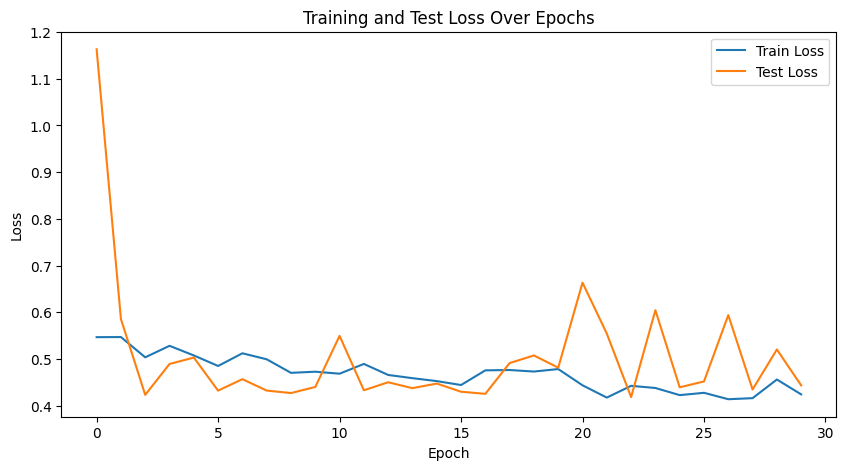

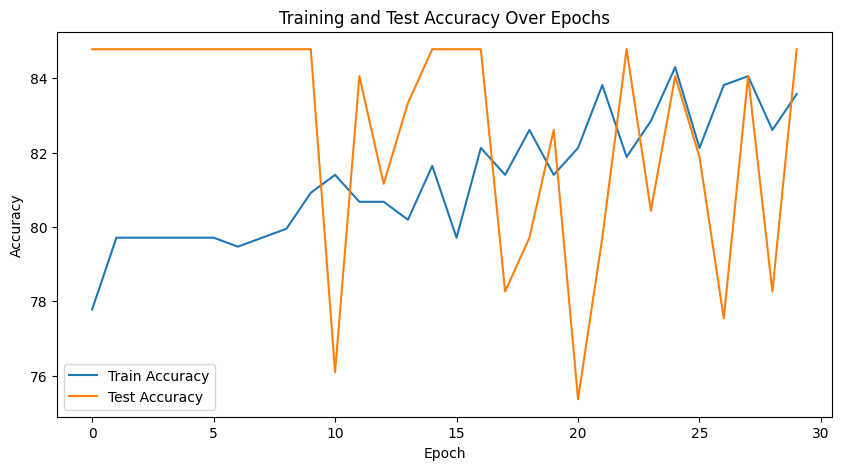

Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       117
           1       0.00      0.00      0.00        21

    accuracy                           0.85       138
   macro avg       0.42      0.50      0.46       138
weighted avg       0.72      0.85      0.78       138

AUC 0.5918


/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

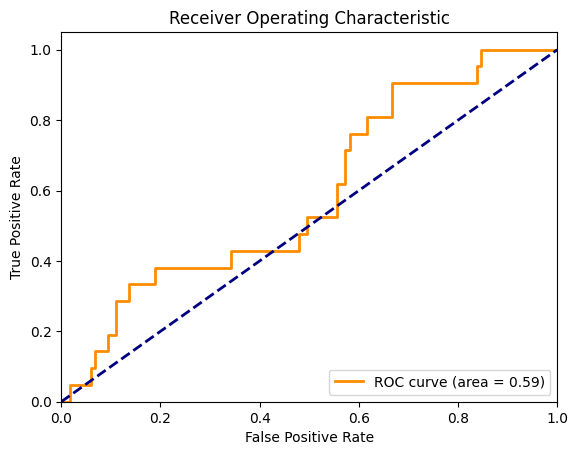

In [31]:
# 确定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化模型、损失函数、优化器
model = SimpleNeuralNetwork(input_size=X_train.shape[1], num_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 数据
from torch.utils.data import Dataset
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # 转换为torch.Tensor
        self.y = torch.tensor(y, dtype=torch.long)  # 转换为torch.Tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# train_dataset = NumpyDataset(np.expand_dims(X_train_sc, axis=1), y_train)
train_dataset = NumpyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# test_dataset = NumpyDataset(np.expand_dims(X_test_sc, axis=1), y_test)
test_dataset = NumpyDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 实例化训练器
trainer = ModelTrainer(model, criterion, optimizer, num_epochs=30, train_loader=train_dataloader, test_loader=test_dataloader, device=device)

# 开始训练
trainer.train()

# 保存最优模型
trainer.save_best_model()

# 测试集评估和绘制ROC曲线
trainer.test_with_best_model()

In [32]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_encoder_layers, num_classes):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, model_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # 输入 x 的形状为 (batch_size, sequence_length)
        # 嵌入后形状为 (batch_size, sequence_length, model_dim)
        x = self.input_embedding(x)
        # 转换维度到 (sequence_length, batch_size, model_dim) 以符合 Transformer 的输入要求
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        # 取序列最后一个元素的输出
        x = x[:, -1, :]
        x = self.output_layer(x)
        return x

/Users/lijingquan/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30, Train Loss: 0.7115, Train Acc: 77.05%
Test Loss: 0.4702, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 2/30, Train Loss: 0.5346, Train Acc: 79.71%
Test Loss: 0.4329, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 3/30, Train Loss: 0.5146, Train Acc: 79.71%
Test Loss: 0.4834, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 4/30, Train Loss: 0.5454, Train Acc: 79.71%
Test Loss: 0.4434, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 5/30, Train Loss: 0.5321, Train Acc: 79.71%
Test Loss: 0.4590, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 6/30, Train Loss: 0.5219, Train Acc: 79.71%
Test Loss: 0.4436, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 7/30, Train Loss: 0.5261, Train Acc: 79.71%
Test Loss: 0.4314, Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Epoch 8/30, Train Loss: 0.5087, Train Acc: 79.71%
Test Loss: 0.4288, Test Acc: 84.7

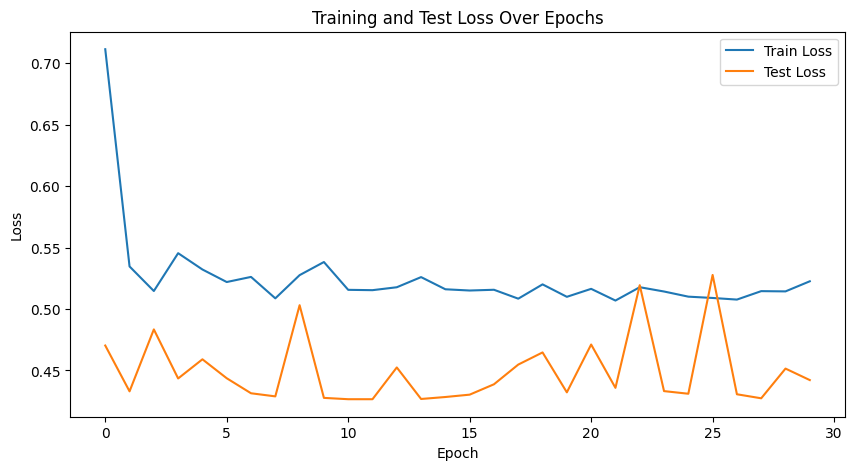

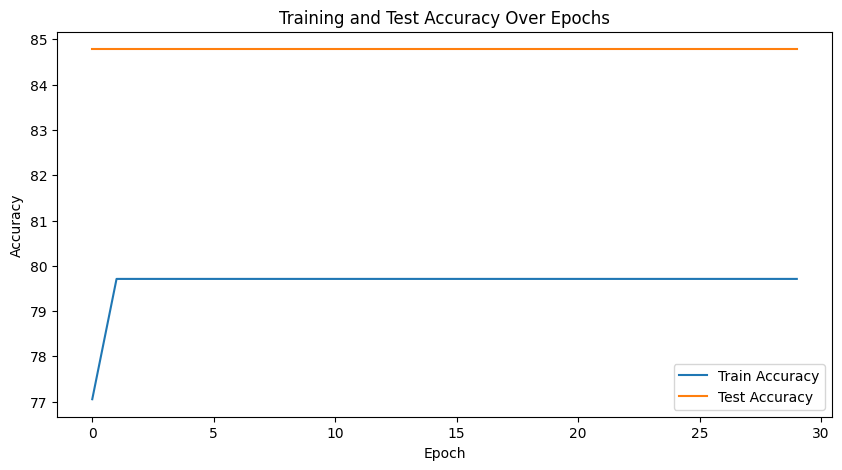

Test Acc: 84.78%
Confusion matrix :- 
 [[117   0]
 [ 21   0]]
Classification Report:-
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       117
           1       0.00      0.00      0.00        21

    accuracy                           0.85       138
   macro avg       0.42      0.50      0.46       138
weighted avg       0.72      0.85      0.78       138

AUC 0.4837


/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lijingquan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

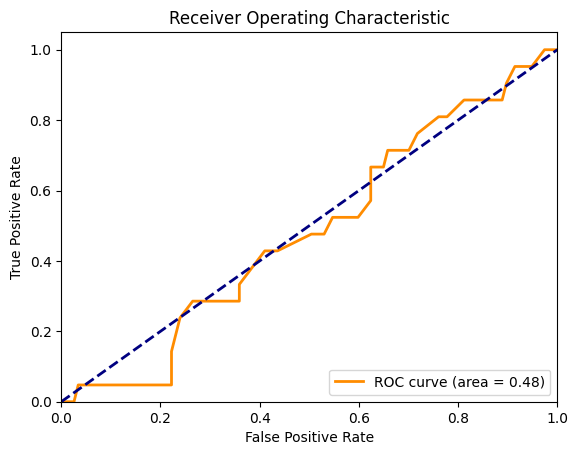

In [33]:
# 确定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化模型、损失函数、优化器
model = TransformerModel(input_dim=240, model_dim=512, nhead=8, num_encoder_layers=3, num_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 数据
from torch.utils.data import Dataset
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # 转换为torch.Tensor
        self.y = torch.tensor(y, dtype=torch.long)  # 转换为torch.Tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# train_dataset = NumpyDataset(np.expand_dims(X_train_sc, axis=1), y_train)
train_dataset = NumpyDataset(X_train_sc, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# test_dataset = NumpyDataset(np.expand_dims(X_test_sc, axis=1), y_test)
test_dataset = NumpyDataset(X_test_sc, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 实例化训练器
trainer = ModelTrainer(model, criterion, optimizer, num_epochs=30, train_loader=train_dataloader, test_loader=test_dataloader, device=device)

# 开始训练
trainer.train()

# 保存最优模型
trainer.save_best_model()

# 测试集评估和绘制ROC曲线
trainer.test_with_best_model()